In [1]:
import pandas as pd
import numpy as np
import torch
import re
import tqdm


from torchtext.data import Field
from torchtext.data import TabularDataset
from torchtext.data import Iterator, BucketIterator

from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## Dataset

In [3]:
dataset=pd.read_csv('data/final_data.csv')

In [4]:
dataset.head()

,Unnamed: 0,id,count,hate_speech,offensive_language,neither,class,tweet
0,0,0,3,0,0,1,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,1,3,0,1,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,2,3,0,1,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,3,0,1,0,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,4,6,0,1,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [5]:
stop_words= set(stopwords.words('english'))

# Cleaning tweets

In [6]:

def clean_tweet(tweet):
    tweet = re.sub("#", "",tweet) # Removing '#' from hashtags
    tweet = re.sub("[^a-zA-Z#]", " ",tweet) # Removing punctuation and special characters
    tweet = re.sub(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+',"<URL>", tweet)
    tweet = re.sub('http','',tweet)
    tweet = re.sub(" +", " ", tweet)
    tweet = tweet.lower()
    tweet = word_tokenize(tweet)
    return tweet
    return_tweet=[]
    for word in tweet:
        if word not in stop_words:
            return_tweet.append(word)
    return return_tweet

In [7]:
TEXT = Field(sequential=True, tokenize=clean_tweet, lower=True)
LABEL = Field(sequential=False, use_vocab=False)


# Building iterator for dataset

In [8]:
dataset_datafields = [("",None),("id",None),("count", None),
                      ("hate_speech", LABEL),("offensive_language", LABEL),
                      ("neither", LABEL),("label", None),("tweet",TEXT)
                    ]

data = TabularDataset(
        path="data/final_data.csv", # the root directory where the data lies
        format='csv',
        skip_header=True, # if your csv header has a header, make sure to pass this to ensure it doesn't get proceesed as data!
        fields=dataset_datafields)
train,test,valid=data.split([0.8,0.1,0.1])

In [9]:
TEXT.build_vocab(train)


In [10]:

train_iter, val_iter = BucketIterator.splits(
        (train, valid), # we pass in the datasets we want the iterator to draw data from
        batch_sizes=(64, 64),
        device=device, # if you want to use the GPU, specify the GPU number here
        sort_key=lambda x: len(x.tweet), # the BucketIterator needs to be told what function it should use to group the data.
        sort_within_batch=False,
        repeat=False # we pass repeat=False because we want to wrap this Iterator layer.
)
test_iter = Iterator(test, batch_size=64, device=device, sort=False, sort_within_batch=False, repeat=False)

In [11]:
class BatchWrapper:
    def __init__(self, dl, x_var, y_vars):
        self.dl, self.x_var, self.y_vars = dl, x_var, y_vars # we pass in the list of attributes for x and y

    
    def __iter__(self):
        for batch in self.dl:
            x = getattr(batch, self.x_var) # we assume only one input in this wrapper
            if self.y_vars is not None: # we will concatenate y into a single tensor
                y = torch.cat([getattr(batch, feat).unsqueeze(1) for feat in self.y_vars], dim=1).float()
            else:
                y = torch.zeros((1))

            yield (x, y)
    
    def __len__(self):
        return len(self.dl)

In [12]:

train_dl = BatchWrapper(train_iter, "tweet", ["hate_speech","offensive_language","neither"])
test_dl = BatchWrapper(test_iter, "tweet", ["hate_speech","offensive_language","neither"])
val_dl = BatchWrapper(val_iter, "tweet", ["hate_speech","offensive_language","neither"])


# MODEL

In [13]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [26]:
class SimpleBiLSTMBaseline(nn.Module):
    def __init__(self, hidden_dim, emb_dim=300,
                 spatial_dropout=0.05, recurrent_dropout=0.1, num_linear=1):
        super().__init__() # don't forget to call this!
        self.embedding = nn.Embedding(len(TEXT.vocab), emb_dim)
        self.encoder = nn.LSTM(emb_dim, hidden_dim, num_layers=1, dropout=recurrent_dropout)
        self.linear_layers = []
        for _ in range(num_linear - 1):
            self.linear_layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.linear_layers = nn.ModuleList(self.linear_layers)
        self.predictor = nn.Linear(hidden_dim, 3)
    
    def forward(self, seq):
        hdn, _ = self.encoder(self.embedding(seq))
        feature = hdn[-1, :, :]
        for layer in self.linear_layers:
            feature = layer(feature)
        preds = self.predictor(feature)
        return preds

In [28]:
em_sz = 200
nh = 500
nl = 5
model = SimpleBiLSTMBaseline(nh, emb_dim=em_sz)
model = model.cuda()
model

/home/yashaswi.pathak/.local/lib/python3.5/site-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


SimpleBiLSTMBaseline(
  (embedding): Embedding(30611, 200)
  (encoder): LSTM(200, 500, dropout=0.1)
  (linear_layers): ModuleList()
  (predictor): Linear(in_features=500, out_features=3, bias=True)
)

In [29]:
opt = optim.Adam(model.parameters(), lr=1e-2)
loss_func = nn.BCEWithLogitsLoss()
epochs=10

In [30]:
training_losses=[]
validation_losses=[]
for epoch in range(1, epochs + 1):
    running_loss = 0.0
    running_corrects = 0
    model.train() # turn on training mode
    for x,y in tqdm.tqdm(train_dl): # thanks to our wrapper, we can intuitively iterate over our data!
        opt.zero_grad()
        
        preds = model(x)
        loss = loss_func(preds, y)
        loss.backward()
        opt.step()
        
        running_loss += loss.data.item() * x.size(0)
        
    epoch_loss = running_loss / len(train)
    
    # calculate the validation loss for this epoch
    val_loss = 0.0
    model.eval() # turn on evaluation mode
    for x,y in val_dl:
        preds = model(x)
        loss = loss_func(preds, y)
        val_loss += loss.data.item() * x.size(0)

    val_loss /= len(valid)
    training_losses.append(epoch_loss)
    validation_losses.append(val_loss)
    print('Epoch: {}, Training Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch, epoch_loss, val_loss))

  4%|▎         | 11/310 [00:00<00:02, 107.72it/s]

Epoch: 1, Training Loss: 0.1938, Validation Loss: 0.1007


  4%|▎         | 11/310 [00:00<00:02, 107.53it/s]

Epoch: 2, Training Loss: 0.1928, Validation Loss: 0.1012


  4%|▎         | 11/310 [00:00<00:02, 107.84it/s]

Epoch: 3, Training Loss: 0.1868, Validation Loss: 0.0854


  4%|▍         | 12/310 [00:00<00:02, 112.85it/s]

Epoch: 4, Training Loss: 0.1091, Validation Loss: 0.0582


  4%|▎         | 11/310 [00:00<00:02, 106.99it/s]

Epoch: 5, Training Loss: 0.0889, Validation Loss: 0.0618


  4%|▎         | 11/310 [00:00<00:02, 109.72it/s]

Epoch: 6, Training Loss: 0.0768, Validation Loss: 0.0571


  4%|▎         | 11/310 [00:00<00:02, 109.09it/s]

Epoch: 7, Training Loss: 0.0680, Validation Loss: 0.0611


  4%|▎         | 11/310 [00:00<00:02, 107.31it/s]

Epoch: 8, Training Loss: 0.0612, Validation Loss: 0.0626


  4%|▍         | 12/310 [00:00<00:02, 113.16it/s]

Epoch: 9, Training Loss: 0.0549, Validation Loss: 0.0647


100%|██████████| 310/310 [00:02<00:00, 140.88it/s]

Epoch: 10, Training Loss: 0.0502, Validation Loss: 0.0683


# Results

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [32]:
accuracy=0
count=0
y_pred=[]
y_actual=[]
for x,y in test_dl:
    
    preds = model(x)
    preds = F.softmax(preds,1)
    for idx,p in enumerate(preds):
        curr_pred=np.round(p.detach().tolist())
        curr_gt=np.round(y[idx].tolist())
        y_pred.append(np.argmax(curr_pred))
        y_actual.append(np.argmax(curr_gt))
        if np.array_equal(curr_pred,curr_gt):
            accuracy+=1
        count+=1


### Results on test set

In [33]:
f = f1_score(y_actual, y_pred, average='micro')
print("F1 Score: ", f)
p = precision_score(y_actual, y_pred, average='micro')
print("Precision Score: ", p)
r = recall_score(y_actual, y_pred, average='micro')
print("Recall Score: ", r)
print("Accuracy: ", accuracy/count)

F1 Score:  0.8789834610730133
Precision Score:  0.8789834610730133
Recall Score:  0.8789834610730133
Accuracy:  0.8781766841468334


### Training and validation loss with epoch

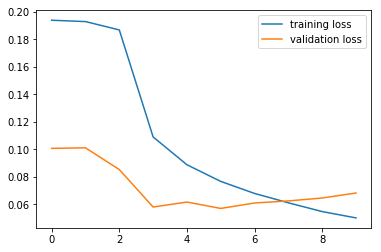

In [34]:
plt.plot(training_losses,label="training loss")
plt.plot(validation_losses,label="validation loss")
plt.legend()

In [49]:
for x,y in test_dl:
    print(x,y)
    break

tensor([[  84,    5,   48,  ...,   35,  309,    0],
        [   9,    0,    2,  ...,   45, 2988,  147],
        [ 545,   35,  105,  ...,   32,  309,   73],
        ...,
        [   1,   57,    1,  ...,    1,   62,    1],
        [   1, 3175,    1,  ...,    1,   20,    1],
        [   1,    0,    1,  ...,    1,   17,    1]], device='cuda:0') tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.